### We take in the pkl_glucose_info file that contains everything we need: 
### The actual time-series Glucose data, the 6 processed statistics from the time series and the labels (study_group_id)

In [1]:
#parameters
experiment_count=1

In [2]:
from model import CNN1DBinaryClassifier,TransformerFusion,CGM2DCNN
from cgm_dataset_transform import GlucoseTransform,CGMDataset,print_results,CyclicShift, Compose
from train_model import train_cgm_classifier
from test_model import do_test
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import DataLoader 
import pickle
import numpy as np

In [3]:
pkl_glucose_info = "dataframe_with_glucose_info.pkl"
dfc = pd.read_csv("HbA1c_all_patients.csv")
df2= pd.read_csv("C:\\Users\\preet\\Documents\\ai-readi-notebooks\\main\\metadata_diseases\\conditions_all.csv")
df2.rename(columns={'participant_id':'patient_ids'},inplace=True)
df2 = df2[['patient_ids','mhterm_dm2, Type II Diabetes']] #, 'mhterm_predm, Pre-diabetes']]
print(df2.columns)

Index(['patient_ids', 'mhterm_dm2, Type II Diabetes'], dtype='object')


In [4]:
dataframe_with_glucose_values_diabetes = pd.read_pickle(pkl_glucose_info)
df = dataframe_with_glucose_values_diabetes
print(df.shape)
print(df2.shape)
df = df.merge(df2, on="patient_ids")
print(df.shape)

df = df[df['patient_ids'].isin(dfc['participant_id'])]

print(df.shape)
# Pick only patients corresponding to prediabetes/life-style controlled diabetes and diabetes with medications.
df = df[df['study_group_id'].isin([1,2])]
#df.loc[df['study_group_id'] == 0, 'study_group_id'] = 1
#df.loc[df['study_group_id'] == 3, 'study_group_id'] = 2

df['study_group_id'] = df['study_group_id'] - 1
print(df.shape)

(1011, 10)
(1067, 2)
(1011, 11)
(965, 11)
(511, 11)


In [5]:
print(df['study_group_id'].value_counts())

df['diabetes_status'] = df['study_group_id']

study_group_id
1    291
0    220
Name: count, dtype: int64
278
278


In [6]:
# Split into train val and test, use the recommendations in the AI READI dataset
df_train = df[df['recommended_split'] == 'train']
df_val   = df[df['recommended_split'] == 'val']
df_test  = df[df['recommended_split'] == 'test']
train_df = df_train.reset_index(drop=True)
val_df   = df_val.reset_index(drop=True)
test_df  = df_test.reset_index(drop=True)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,f1_score,classification_report
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.metrics import balanced_accuracy_score
col = 'diabetes_status' 

cols_to_drop = ["patient_ids", "Glucose Lists", "study_group_id","recommended_split",'mhterm_dm2, Type II Diabetes','diabetes_status']
X_train =  train_df.drop(columns=cols_to_drop)
y_train = train_df[col]
X_val =  val_df.drop(columns=cols_to_drop)
y_val = val_df[col]
X_test =  test_df.drop(columns=cols_to_drop)
y_test = test_df[col] 
print(X_test.columns)
# --- Hyperparameter options ---
n_estimators_list = [64, 128, 256, 512]
max_depth_list = [None, 10, 20]
best_ba = -1
best_rf = None

for n_trees in n_estimators_list:
    for depth in max_depth_list:
            
            rf = RandomForestClassifier(
                n_estimators=n_trees,
                max_depth=depth,
                class_weight="balanced",     # <-- improves balanced accuracy
               # random_state=42,
                n_jobs=-1
            )

            # Train
            rf.fit(X_train, y_train)

            # Validate
            y_val_pred = rf.predict(X_val)
            y_val_prob = rf.predict_proba(X_val)[:, 1]

            ba = balanced_accuracy_score(y_val, y_val_pred)

            print(f"BA={ba:.4f} | trees={n_trees}, depth={depth}")

            # Save best model
            if ba > best_ba:
                best_ba = ba
                best_rf = rf
                print("→ New best model with BA =", best_ba)

                with open("random_forest_best.pkl", "wb") as f:
                    pickle.dump(best_rf, f)

# --- Load best model ---
with open("random_forest_best.pkl", "rb") as f:
    best_rf = pickle.load(f)

# --- Test evaluation ---
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_prob))
print("AUPRC:", average_precision_score(y_test, y_test_prob))
print("F1 Score:", f1_score(y_test, y_test_pred))

results_rf = print_results(y_test, y_test_prob)
results_rf['model'] = 'RF_features'
results_df = pd.DataFrame([results_rf])



Index(['spike_resolutions', 'expected_daily_spikes', 'mean_glucose',
       'relative_spikes', 'hyper_time_pcts', 'nocturnal_hypoglycemias'],
      dtype='object')
BA=0.7086 | trees=64, depth=None
→ New best model with BA = 0.7086466165413534
BA=0.7350 | trees=64, depth=10
→ New best model with BA = 0.7349624060150376
BA=0.7350 | trees=64, depth=20
BA=0.6573 | trees=128, depth=None
BA=0.6717 | trees=128, depth=10
BA=0.7337 | trees=128, depth=20
BA=0.7206 | trees=256, depth=None
BA=0.7086 | trees=256, depth=10
BA=0.6955 | trees=256, depth=20
BA=0.6823 | trees=512, depth=None
BA=0.7086 | trees=512, depth=10
BA=0.6692 | trees=512, depth=20

=== Test Metrics ===
Accuracy: 0.7027027027027027
Balanced Accuracy: 0.6945054945054945
Confusion Matrix:
 [[19 16]
 [ 6 33]]
ROC AUC: 0.7516483516483518
AUPRC: 0.7759540619352892
F1 Score: 0.75
Accuracy: 0.7027027027027027
Balanced Accuracy: 0.6945054945054945

Confusion Matrix:
 [[19 16]
 [ 6 33]]

Classification Report:
               precision    r

Original shape: (288,)


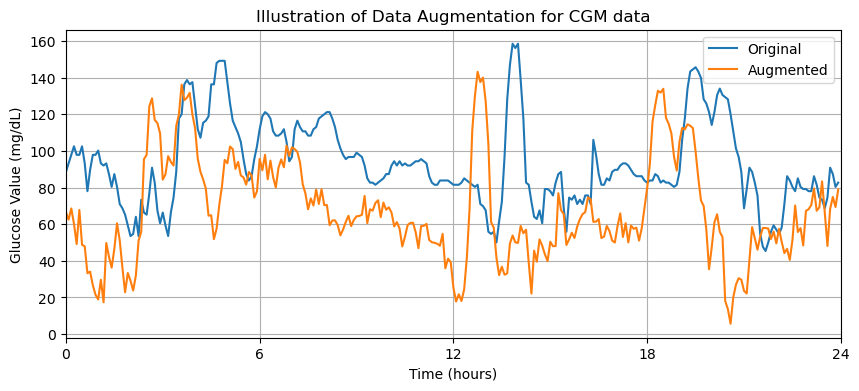

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Original dataset (no transform)
dataset = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode=0, transform=None)

x_orig = dataset[0][0].squeeze().numpy()  
x_orig = x_orig * 140 + 120   # rescale
print("Original shape:", x_orig.shape)

# Create time axis in hours (288 * 5min = 1440min = 24h)
time_axis = np.arange(len(x_orig)) * 5 / 60.0  # hours

plt.figure(figsize=(10,4))
plt.plot(time_axis, x_orig, label="Original")

# Dataset with transform
glucose_transform = GlucoseTransform(add_range=(-0.3,0.3), alpha_range =(0.8,1.2), noise_range=(-0.05,0.05))
augment = Compose([
    CyclicShift(shift_range=(-144, 144)),
    glucose_transform
    
])



dataset_aug = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode=0, transform=augment)

x_aug = dataset_aug[0][0].squeeze().numpy()
x_aug = x_aug * 140 + 120

plt.plot(time_axis, x_aug, label="Augmented")

# Formatting
plt.title("Illustration of Data Augmentation for CGM data")
plt.xlabel("Time (hours)")
plt.ylabel("Glucose Value (mg/dL)")
plt.xlim(0, 24)                     # force axis from 0 to 24
plt.xticks(np.arange(0, 25, 6))     # ticks every 6 hours
plt.legend()
plt.grid(True)
plt.show()


In [9]:
#train on entire week of data and test 1D CNN

label_col = col
print(col)
print(train_df.columns)
#glucose_transform = GlucoseTransform(add_range=(-0.2,0.2), alpha_range =(0.9,1.1), noise_range=(-0.05,0.05))

glucose_transform = GlucoseTransform(add_range=(-0.3,0.3), alpha_range =(0.8,1.2), noise_range=(-0.05,0.05))
# Dataset with transform

augment = Compose([
    CyclicShift(shift_range=(-144*7, 144*7)),
    glucose_transform
])
dataset  = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode = 1, transform = augment)
loader   = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = CGMDataset(val_df, seq_col='Glucose Lists', label_col=col,offset=0,  mode = 1)
val_dataloader  = DataLoader(val_dataset, batch_size=32,shuffle=False)
model    = CNN1DBinaryClassifier(num_classes=2)
#model = CGM2DCNN()
probs,best_model  = train_cgm_classifier(
        loader,val_dataloader, model,
        epochs=30,
        lr=1e-4,
        mode = 1
    )
torch.save(best_model.state_dict(), "best_model_cgm_cnn_week.pth")

prob_list = []
labels_list = []

model = CNN1DBinaryClassifier(num_classes=2)

state_dict = torch.load("best_model_cgm_cnn_week.pth")
model.load_state_dict(state_dict) 
model.to("cuda")

test_dataset = CGMDataset(test_df, seq_col='Glucose Lists',
                          label_col=col,
                          offset=0, mode=1)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import torch
import torch.nn as nn

# ----- Run test -----
probs, labels, loss = do_test(model, test_loader, criterion=nn.CrossEntropyLoss())

# Convert to NumPy arrays
probs = np.vstack(probs)  # shape (N, 2)
labels = np.array([int(l.item()) for l in labels])  # shape (N,)

# Extract probability for the positive class (class 1)
y_prob = probs[:, 1]
y_true = labels
results_cnn_week = print_results(y_true, y_prob)
results_cnn_week['model'] = 'CNN1D_Week'

results_df = results_df._append(results_cnn_week, ignore_index=True)

diabetes_status
Index(['patient_ids', 'Glucose Lists', 'spike_resolutions',
       'expected_daily_spikes', 'mean_glucose', 'relative_spikes',
       'hyper_time_pcts', 'nocturnal_hypoglycemias', 'recommended_split',
       'study_group_id', 'mhterm_dm2, Type II Diabetes', 'diabetes_status'],
      dtype='object')
Model Parameters: 3,058,370
Class Weights: [1.1761364 0.8238636]
Epoch 1/30 — Loss: 0.6835 — Accuracy: 0.4119 - Val Loss: 0.6914
Best Val Loss 0.6913965106010437
Epoch 2/30 — Loss: 0.6784 — Accuracy: 0.5341 - Val Loss: 0.6863
Best Val Loss 0.686274778842926
Epoch 3/30 — Loss: 0.6534 — Accuracy: 0.6648 - Val Loss: 0.6645
Best Val Loss 0.6645454287528991
Epoch 4/30 — Loss: 0.6261 — Accuracy: 0.6705 - Val Loss: 0.6357
Best Val Loss 0.6357187271118164
Epoch 5/30 — Loss: 0.5899 — Accuracy: 0.6477 - Val Loss: 0.6287
Best Val Loss 0.6286871790885925
Epoch 6/30 — Loss: 0.6285 — Accuracy: 0.6733 - Val Loss: 0.6333
Epoch 7/30 — Loss: 0.6336 — Accuracy: 0.5938 - Val Loss: 0.6501
Epoch 8

In [10]:
#train on entire week of data and test 2D CNN

label_col = col
print(col)
print(train_df.columns)
#glucose_transform = GlucoseTransform(add_range=(-0.2,0.2), alpha_range =(0.9,1.1), noise_range=(-0.05,0.05))

glucose_transform = GlucoseTransform(add_range=(-0.3,0.3), alpha_range =(0.8,1.2), noise_range=(-0.05,0.05))
# Dataset with transform

augment = Compose([
    CyclicShift(shift_range=(-144*7, 144*7)),
    glucose_transform
])
dataset  = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode = 1, transform = augment)
loader   = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = CGMDataset(val_df, seq_col='Glucose Lists', label_col=col,offset=0,  mode = 1)
val_dataloader  = DataLoader(val_dataset, batch_size=32,shuffle=False)
model = CGM2DCNN()
probs,best_model  = train_cgm_classifier(
        loader,val_dataloader, model,
        epochs=30,
        lr=1e-4,
        mode = 1
    )
torch.save(best_model.state_dict(), "best_model_cgm2d_cnn_week.pth")

prob_list = []
labels_list = []

model = CGM2DCNN()
state_dict = torch.load("best_model_cgm2d_cnn_week.pth")
model.load_state_dict(state_dict) 
model.to("cuda")

test_dataset = CGMDataset(test_df, seq_col='Glucose Lists',
                          label_col=col,
                          offset=0, mode=1)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import torch
import torch.nn as nn

# ----- Run test -----
probs, labels, loss = do_test(model, test_loader, criterion=nn.CrossEntropyLoss())

# Convert to NumPy arrays
probs = np.vstack(probs)  # shape (N, 2)
labels = np.array([int(l.item()) for l in labels])  # shape (N,)

# Extract probability for the positive class (class 1)
y_prob = probs[:, 1]
y_true = labels
results_cnn_week = print_results(y_true, y_prob)
results_cnn_week['model'] = 'CNN2D_Week'

results_df = results_df._append(results_cnn_week, ignore_index=True)

diabetes_status
Index(['patient_ids', 'Glucose Lists', 'spike_resolutions',
       'expected_daily_spikes', 'mean_glucose', 'relative_spikes',
       'hyper_time_pcts', 'nocturnal_hypoglycemias', 'recommended_split',
       'study_group_id', 'mhterm_dm2, Type II Diabetes', 'diabetes_status'],
      dtype='object')
Model Parameters: 8,356,706
Class Weights: [1.1761364 0.8238636]
Epoch 1/30 — Loss: 0.8039 — Accuracy: 0.6477 - Val Loss: 0.6857
Best Val Loss 0.6856742382049561
Epoch 2/30 — Loss: 0.6875 — Accuracy: 0.4375 - Val Loss: 0.6898
Epoch 3/30 — Loss: 0.6761 — Accuracy: 0.6392 - Val Loss: 0.6902
Epoch 4/30 — Loss: 0.6687 — Accuracy: 0.6250 - Val Loss: 0.6812
Best Val Loss 0.6811521530151368
Epoch 5/30 — Loss: 0.6581 — Accuracy: 0.6562 - Val Loss: 0.6723
Best Val Loss 0.6723254561424256
Epoch 6/30 — Loss: 0.6397 — Accuracy: 0.6648 - Val Loss: 0.6602
Best Val Loss 0.6602206110954285
Epoch 7/30 — Loss: 0.6219 — Accuracy: 0.6705 - Val Loss: 0.6416
Best Val Loss 0.6415554642677307
Epoch 

In [11]:
# First train classifier to take in one day of data and predict the output class
# Then compute probabilities by feeding each day of data at a time
# Take the mean of the probabilities to determine final classification probability.
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
label_col = col
print(col)
print(train_df.columns)
glucose_transform = GlucoseTransform(add_range=(-0.3,0.3), alpha_range =(0.8,1.2), noise_range=(-0.05,0.05))
# Dataset with transform

augment = Compose([
    CyclicShift(shift_range=(-144, 144)),
    glucose_transform
])

dataset  = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode = 0, transform = augment)
loader   = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataset = CGMDataset(val_df, seq_col='Glucose Lists', label_col=col,offset=0,  mode = 0)
val_dataloader  = DataLoader(val_dataset, batch_size=32,shuffle=False)

model    = CNN1DBinaryClassifier(num_classes=2)

probs, best_model  = train_cgm_classifier(
        loader,val_dataloader, model,
        epochs=30,
        lr=1e-4,
        mode =0
    )

torch.save(best_model.state_dict(), "best_model_cgm_cnn_day.pth")


prob_list = []
labels_list = []
print(col)
model = CNN1DBinaryClassifier(num_classes=2)
state_dict = torch.load("best_model_cgm_cnn_day.pth")
model.load_state_dict(state_dict) 
model.to("cuda")
model.eval()
for i in range(7):
    test_dataset = CGMDataset(test_df, seq_col='Glucose Lists',
                              label_col=col,
                              offset=i, mode=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    probs, labels, loss = do_test(model, test_loader, criterion =nn.CrossEntropyLoss())
    
    prob_list.append(probs)   # Shape: (num_patients,) → each day = row
    labels_list.append(labels)  # Same shape

import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

# prob_list and labels_list are currently lists of arrays (len = 7)
# Stack them: shape (7, N) where N = number of patients
probs_all = np.stack(prob_list, axis=0)       # shape: (7, N, 2) if probs are softmax for both classes
labels_all = np.stack(labels_list, axis=0)    # shape: (7, N)


# If probs are 2D (N,2), we need column 1
if probs_all.ndim == 3:
    probs_all = probs_all[..., 1]   # shape (7, N)

probs_all2 = probs_all
probs_max = probs_all2.mean(axis=0)   # shape (N,)

# All days should have the same labels, so just take the first
labels = labels_all[0]              # shape (N,)

print(probs_max)
results_cnn_day_max = print_results(labels, probs_max)
results_cnn_day_max['model'] = 'CNN1D_DAILY_MAX'

results_df = results_df._append(results_cnn_day_max, ignore_index=True)

diabetes_status
Index(['patient_ids', 'Glucose Lists', 'spike_resolutions',
       'expected_daily_spikes', 'mean_glucose', 'relative_spikes',
       'hyper_time_pcts', 'nocturnal_hypoglycemias', 'recommended_split',
       'study_group_id', 'mhterm_dm2, Type II Diabetes', 'diabetes_status'],
      dtype='object')
Model Parameters: 3,058,370
Class Weights: [1.1764706 0.8235294]
Epoch 1/30 — Loss: 0.6559 — Accuracy: 0.6343 - Val Loss: 0.6374
Best Val Loss 0.6374336412974766
Epoch 2/30 — Loss: 0.6298 — Accuracy: 0.6395 - Val Loss: 0.6385
Epoch 3/30 — Loss: 0.6191 — Accuracy: 0.6511 - Val Loss: 0.6441
Epoch 4/30 — Loss: 0.6197 — Accuracy: 0.6507 - Val Loss: 0.6450
Epoch 5/30 — Loss: 0.6126 — Accuracy: 0.6515 - Val Loss: 0.6367
Best Val Loss 0.6366682427270072
Epoch 6/30 — Loss: 0.6116 — Accuracy: 0.6467 - Val Loss: 0.6395
Epoch 7/30 — Loss: 0.6077 — Accuracy: 0.6575 - Val Loss: 0.6324
Best Val Loss 0.6323584198951722
Epoch 8/30 — Loss: 0.6056 — Accuracy: 0.6559 - Val Loss: 0.6574
Epoch 9/

## Next step use a transformer to fuse embeddings per day. The model is initialized with the pre-trained weights


        

In [27]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN1DBinaryClassifier(num_classes=2)

cnn_model.load_state_dict(torch.load('best_model_cgm_cnn_day.pth'))


fusion_model = TransformerFusion(cnn_model)
fusion_model = fusion_model.to(device)

glucose_transform = GlucoseTransform(add_range=(-0.3,0.3), alpha_range =(0.8,1.2), noise_range=(-0.05,0.05))
# Dataset with transform

augment = Compose([
    CyclicShift(shift_range=(-144*7, 144*7)),
    glucose_transform
])
dataset  = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode = 1, transform=augment)
loader   = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataset = CGMDataset(val_df, seq_col='Glucose Lists', label_col=col,offset=0,  mode = 1)
val_dataloader  = DataLoader(val_dataset, batch_size=32,shuffle=False)
test_dataset = CGMDataset(test_df, seq_col='Glucose Lists', label_col=col,offset=0,  mode = 1)
test_dataloader  = DataLoader(test_dataset, batch_size=32,shuffle=False)


probs, best_model  = train_cgm_classifier(
        loader,val_dataloader, fusion_model,
        epochs=30,
        lr=1e-5,
        mode=1
    )

torch.save(best_model.state_dict(), "best_model_cgm_transformer_week.pth")


Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (1): ReLU()
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (3): ReLU()
  (4): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (5): ReLU()
  (6): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
  (7): ReLU()
  (8): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU()
  (10): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (11): ReLU()
  (12): Conv1d(512, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
  (13): ReLU()
  (14): AdaptiveAvgPool1d(output_size=1)
)
Model Parameters: 9,641,668
Class Weights: [1.1764706 0.8235294]
Epoch 1/30 — Loss: 0.6527 — Accuracy: 0.6078 - Val Loss: 0.6014
Best Val Loss 0.6013730645179749
Epoch 2/30 — Loss: 0.5574 — Accuracy: 0.7283 - Val Loss: 0.5830
Best Val Loss 0.583026933670044
Epoch 3/30 — Loss: 0.5620 — Accuracy: 0.7115 - Val Loss: 0.6032
Epoch 4/30 — Loss: 0.5595 — Accuracy: 0.728

In [28]:

#Finally get the test results
prob_list = []
labels_list = []

fusion_model = TransformerFusion(cnn_model)
fusion_model = fusion_model.to(device)

fusion_model.load_state_dict(torch.load("best_model_cgm_transformer_week.pth"))

fusion_model.to("cuda")
fusion_model.eval()

test_dataset = CGMDataset(test_df, seq_col='Glucose Lists',
                          label_col=col,
                          offset=0, mode=1)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
probs, labels, loss  = do_test(fusion_model, test_loader, criterion =nn.CrossEntropyLoss())
# Convert to NumPy arrays
probs = np.vstack(probs)  # shape (N, 2)
labels = np.array([int(l.item()) for l in labels])  # shape (N,)

# Extract probability for the positive class (class 1)
y_prob = probs[:, 1]
y_true = labels
results_transformer = print_results(y_true, y_prob)
results_transformer['model'] = 'Transformer'

results_df = results_df._append(results_transformer, ignore_index=True)


Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (1): ReLU()
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (3): ReLU()
  (4): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (5): ReLU()
  (6): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
  (7): ReLU()
  (8): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU()
  (10): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (11): ReLU()
  (12): Conv1d(512, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
  (13): ReLU()
  (14): AdaptiveAvgPool1d(output_size=1)
)
Accuracy: 0.7162162162162162
Balanced Accuracy: 0.7219780219780221

Confusion Matrix:
 [[29  6]
 [15 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.83      0.73        35
           1       0.80      0.62      0.70        39

    accuracy                           0.72        74
   macro avg    

In [14]:
#XGBoost + PCA
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score, roc_auc_score,
    f1_score, confusion_matrix, average_precision_score, classification_report
)
from xgboost import XGBClassifier

# Prepare arrays
X_train = dataset.X.squeeze()
y_train = dataset.y.squeeze()
X_val   = val_dataset.X.squeeze()
y_val   = val_dataset.y.squeeze()
X_test  = test_dataset.X.squeeze()
y_test  = test_dataset.y.squeeze()

print("Train shape:", X_train.shape)

# -----------------------------------------------------------
# Hyperparameter grids (now includes PCA n_components)
# -----------------------------------------------------------

pca_components_list = [0.90, 0.95, 0.98, 0.99]

n_estimators_list  = [100, 300, 500]
learning_rates     = [0.01, 0.05, 0.1]
max_depths         = [3, 4, 5]
subsamples         = [0.8, 1.0]
colsample_bytree_s = [0.8, 1.0]

# Balanced accuracy tracking
best_ba = -1
best_pipeline = None
best_params = None

N = 2016  # ensure consistent slicing

# -----------------------------------------------------------
# Manual Grid Search Loop
# -----------------------------------------------------------

for pca_comp in pca_components_list:
    for n_est in n_estimators_list:
            for md in max_depths:


                        pipeline = Pipeline([
                            ("scaler", StandardScaler()),
                            ("pca", PCA(n_components=pca_comp)),
                            ("xgb", XGBClassifier(
                                n_estimators=n_est,
                                max_depth=md,
                                eval_metric="logloss",
                                tree_method="auto"
                            ))
                        ])

                        # Fit on train
                        pipeline.fit(X_train[:, :N], y_train)

                        # Validate
                        y_val_pred = pipeline.predict(X_val[:, :N])
                        ba = balanced_accuracy_score(y_val, y_val_pred)


                        # Save best model
                        if ba > best_ba:
                            best_ba = ba
                            best_pipeline = pipeline
                            best_params = (pca_comp, n_est, md)
                            print("🔥 New Best Model Found!")

# -----------------------------------------------------------
# Save best model
# -----------------------------------------------------------

print("\nBest Balanced Accuracy:", best_ba)
print("Best hyperparameters:", best_params)

with open("XGBoost_model.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

with open("XGBoost_model.pkl", "rb") as f:
    best_pipeline = pickle.load(f)

# -----------------------------------------------------------
# Test evaluation
# -----------------------------------------------------------

y_test_pred = best_pipeline.predict(X_test[:, :N])
y_test_prob = best_pipeline.predict_proba(X_test[:, :N])[:, 1]

print("\n=== Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_prob))
print("AUPRC:", average_precision_score(y_test, y_test_prob))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

results_xgb = print_results(y_test, y_test_prob)
results_xgb['model'] = 'XGBoost_PCA'

results_df = results_df._append(results_xgb, ignore_index=True)


Train shape: torch.Size([357, 2016])
🔥 New Best Model Found!

Best Balanced Accuracy: 0.6635338345864662
Best hyperparameters: (0.9, 100, 3)

=== Test Metrics ===
Accuracy: 0.6351351351351351
Balanced Accuracy: 0.6333333333333333
Confusion Matrix:
 [[21 14]
 [13 26]]
F1: 0.6582278481012658
ROC AUC: 0.6717948717948719
AUPRC: 0.695829545675093

Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.60      0.61        35
         1.0       0.65      0.67      0.66        39

    accuracy                           0.64        74
   macro avg       0.63      0.63      0.63        74
weighted avg       0.63      0.64      0.63        74

Accuracy: 0.6351351351351351
Balanced Accuracy: 0.6333333333333333

Confusion Matrix:
 [[21 14]
 [13 26]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.60      0.61        35
         1.0       0.65      0.67      0.66        39

    accur

In [15]:
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score, roc_auc_score,
    f1_score, confusion_matrix, classification_report,
    average_precision_score
)
import torch
from tabpfn import TabPFNClassifier

# -----------------------------
# Data
# -----------------------------
X_train = dataset.X.squeeze()
y_train = dataset.y.squeeze()
X_val   = val_dataset.X.squeeze()
y_val   = val_dataset.y.squeeze()
X_test  = test_dataset.X.squeeze()
y_test  = test_dataset.y.squeeze()

print("Train shape:", X_train.shape)

# -----------------------------
# Hyperparameter grid
# -----------------------------
pca_components_list = [0.90, 0.95, 0.98, 0.99]

best_ba = -1
best_model = None
best_scaler = None
best_pca = None
best_pca_val = None

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Search loop
# -----------------------------
for pca_comp in pca_components_list:
    print(f"\n--- Trying PCA n_components = {pca_comp} ---")

    # Fit scaler and PCA only on the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    pca = PCA(n_components=pca_comp)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca   = pca.transform(X_val_scaled)

    print(" PCA output dimension:", X_train_pca.shape[1])

    # Train TabPFN
    clf = TabPFNClassifier(
        device=device
    )
    clf.fit(X_train_pca, y_train)

    # Validation prediction
    y_val_pred = clf.predict(X_val_pca)
    y_val_prob = clf.predict_proba(X_val_pca)[:, 1]

    # Balanced accuracy is our selection metric
    ba = balanced_accuracy_score(y_val, y_val_pred)
    print(" Balanced Accuracy:", ba)

    if ba > best_ba:
        best_ba = ba
        best_model = clf
        best_scaler = scaler
        best_pca = pca
        best_pca_val = pca_comp
        print("🔥 New best model found!")

# -----------------------------
# Save the best model + preprocessing
# -----------------------------

with open("TABPFN_best_model.pkl", "wb") as f:
    pickle.dump({
        "model": best_model,
        "scaler": best_scaler,
        "pca": best_pca,
        "pca_components": best_pca_val,
    }, f)

print("\nBest Balanced Accuracy:", best_ba)
print("Best PCA n_components:", best_pca_val)

# -----------------------------
# Test the best model
# -----------------------------
# Reload for safety
with open("TABPFN_best_model.pkl", "rb") as f:
    saved = pickle.load(f)
best_model = saved["model"]
scaler = saved["scaler"]
pca = saved["pca"]

# Apply best preprocessing
X_test_scaled = scaler.transform(X_test)
X_test_pca    = pca.transform(X_test_scaled)

# Predictions
y_test_pred = best_model.predict(X_test_pca)
y_test_prob = best_model.predict_proba(X_test_pca)[:, 1]

# -----------------------------
# Final Test Metrics
# -----------------------------
print("\n=== Test Metrics ===")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

try:
    print("AUROC:", roc_auc_score(y_test, y_test_prob))
except:
    print("AUROC: Cannot compute (only one class present).")

print("AUPRC:", average_precision_score(y_test, y_test_prob))
print("F1:", f1_score(y_test, y_test_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

results_tab = print_results(y_test, y_test_prob)
results_tab['model'] = 'TABPFN_PCA'

results_df = results_df._append(results_tab, ignore_index=True)

Train shape: torch.Size([357, 2016])

--- Trying PCA n_components = 0.9 ---
 PCA output dimension: 42
 Balanced Accuracy: 0.650375939849624
🔥 New best model found!

--- Trying PCA n_components = 0.95 ---
 PCA output dimension: 74
 Balanced Accuracy: 0.6409774436090225

--- Trying PCA n_components = 0.98 ---
 PCA output dimension: 125
 Balanced Accuracy: 0.6660401002506265
🔥 New best model found!

--- Trying PCA n_components = 0.99 ---
 PCA output dimension: 168
 Balanced Accuracy: 0.6290726817042607

Best Balanced Accuracy: 0.6660401002506265
Best PCA n_components: 0.98

=== Test Metrics ===
Balanced Accuracy: 0.7018315018315018
Accuracy: 0.7027027027027027
AUROC: 0.7531135531135531
AUPRC: 0.8195583324296323
F1: 0.717948717948718

Confusion Matrix:
 [[24 11]
 [11 28]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.69      0.69        35
         1.0       0.72      0.72      0.72        39

    accuracy                    

In [16]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.metrics import balanced_accuracy_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier

X_train = dataset.X.squeeze()
y_train = dataset.y.squeeze()

X_val = val_dataset.X.squeeze()
y_val = val_dataset.y

X_test = test_dataset.X.squeeze()
y_test = test_dataset.y

N = 2016  # ensure slicing is consistent

ba_max = -1
best_pipeline = None

for components in [0.8,0.9, 0.95, 0.98, 0.99]:
    for n_estimators in [64,128, 256, 512]:

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=components)),
            ("rf", RandomForestClassifier(
                n_estimators=n_estimators,
                class_weight="balanced",   # <-- GREAT for balanced accuracy
                #random_state=42
            ))
        ])

        pipeline.fit(X_train[:, :N], y_train)

        y_val_pred = pipeline.predict(X_val[:, :N])
        y_val_prob = pipeline.predict_proba(X_val[:, :N])[:, 1]

        ba = balanced_accuracy_score(y_val, y_val_pred)
        print(f"Balanced Accuracy: {ba:.4f} | PCA={components}, Trees={n_estimators}")

        if ba > ba_max:
            ba_max = ba
            best_pipeline = pipeline
            print("Updated best model:", ba, components, n_estimators)

# Save best model
with open("RF_PCA_model.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

# Load best model
with open("RF_PCA_model.pkl", "rb") as f:
    pipeline = pickle.load(f)

# Test evaluation
y_test_pred = pipeline.predict(X_test[:, :N])
y_test_prob = pipeline.predict_proba(X_test[:, :N])[:, 1]

print("\nTest Metrics")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))
print("AUPRC:", average_precision_score(y_test, y_test_prob))

results_pca_rf = print_results(y_test, y_test_prob)
results_pca_rf['model'] = 'Random_Forest_PCA'
results_df = results_df._append(results_pca_rf, ignore_index=True)

Balanced Accuracy: 0.5990 | PCA=0.8, Trees=64
Updated best model: 0.5989974937343359 0.8 64
Balanced Accuracy: 0.6347 | PCA=0.8, Trees=128
Updated best model: 0.6347117794486216 0.8 128
Balanced Accuracy: 0.6096 | PCA=0.8, Trees=256
Balanced Accuracy: 0.5833 | PCA=0.8, Trees=512
Balanced Accuracy: 0.6228 | PCA=0.9, Trees=64
Balanced Accuracy: 0.6360 | PCA=0.9, Trees=128
Updated best model: 0.6359649122807017 0.9 128
Balanced Accuracy: 0.6347 | PCA=0.9, Trees=256
Balanced Accuracy: 0.6491 | PCA=0.9, Trees=512
Updated best model: 0.6491228070175439 0.9 512
Balanced Accuracy: 0.6241 | PCA=0.95, Trees=64
Balanced Accuracy: 0.6096 | PCA=0.95, Trees=128
Balanced Accuracy: 0.6347 | PCA=0.95, Trees=256
Balanced Accuracy: 0.6216 | PCA=0.95, Trees=512
Balanced Accuracy: 0.5714 | PCA=0.98, Trees=64
Balanced Accuracy: 0.6598 | PCA=0.98, Trees=128
Updated best model: 0.6597744360902256 0.98 128
Balanced Accuracy: 0.5952 | PCA=0.98, Trees=256
Balanced Accuracy: 0.6190 | PCA=0.98, Trees=512
Balanced 

In [18]:
cols = ['model'] + [c for c in results_df.columns if c != 'model']
results_df = results_df[cols]
result_dir = r'C:\\Users\\preet\\Documents\\ai-readi-notebooks\\main\\CGM_diabetes_progression\\results2\\'
results_df.to_csv(result_dir+'AI_READI_no_pretrn_Label_study_dataset_1_2_run_'+str(experiment_count)+'.csv')
results_df.head(20)

,model,AUC,AUPRC,Accuracy,BA,F1
0,RF_features,0.751648,0.775954,0.702703,0.694505,0.750000
1,CNN1D_Week,0.763370,0.819996,0.716216,0.720513,0.704225
2,CNN2D_Week,0.807326,0.848224,0.783784,0.783150,0.794872
3,CNN1D_DAILY_MAX,0.814652,0.870924,0.702703,0.693040,0.755556
4,Transformer,0.836630,0.894222,0.716216,0.710256,0.752941
5,XGBoost_PCA,0.671795,0.695830,0.635135,0.633333,0.658228
6,TABPFN_PCA,0.753114,0.819558,0.702703,0.701832,0.717949
7,Random_Forest_PCA,0.744322,0.752089,0.675676,0.665934,0.733333
